In [1]:
import pandas as pd
import requests
import os
from io import BytesIO
from zipfile import ZipFile
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.size"] = 16
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.loc"] = "upper right"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
# download data from uci ml db
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic (2).zip"

if not os.path.exists("obesity.csv"):
    print("DOWNLOAD")
    resp = requests.get(url).content
    zf = ZipFile(BytesIO(resp))
    for name in zipfile.namelist():
        if "csv" in name:
            print(name)
            df = pd.read_csv(zf.open(name))
            df.to_csv("obesity.csv", index=False)

df = pd.read_csv("obesity.csv")
print(df.shape)
df.head()

(2111, 17)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.isna().values.sum() # no missing value

0

In [5]:
data1 = pd.DataFrame(df.groupby(["Gender","NObeyesdad"]).size()).reset_index()
data1.rename(columns={0:'Counts'}, inplace=True)
ordered = ['Insufficient_Weight', 'Normal_Weight','Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
f = data1[data1["Gender"] == "Female"].set_index("NObeyesdad").reindex(ordered)
m = data1[data1["Gender"] == "Male"].set_index("NObeyesdad").reindex(ordered)
types = list(f.index)
c_f = list(f["Counts"])
c_m = list(m["Counts"])

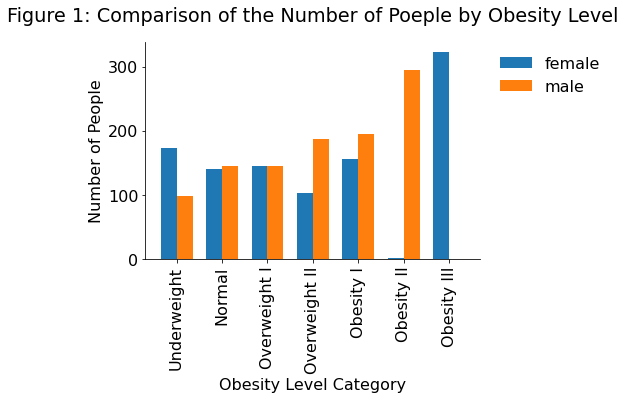

In [6]:
#Figure 1: descriptive stats
bar_width = 0.35  
index_f = np.arange(len(types))  
index_m = index_f + bar_width  

plt.bar(index_f, height=c_f, width=bar_width, label='female')
plt.bar(index_m, height=c_m, width=bar_width, label='male')

label = ['Underweight', 'Normal','Overweight I','Overweight II','Obesity I','Obesity II','Obesity III']
plt.legend()  
plt.xticks(index_f + bar_width/2, label, rotation=90)
plt.xlabel("Obesity Level Category")
plt.ylabel("Number of People")  
plt.title("Figure 1: Comparison of the Number of Poeple by Obesity Level", pad = 20)  
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', ncol=1)
plt.show()

In [23]:
data1

,Gender,NObeyesdad,Counts
0,Female,Insufficient_Weight,173
1,Female,Normal_Weight,141
2,Female,Obesity_Type_I,156
3,Female,Obesity_Type_II,2
4,Female,Obesity_Type_III,323
5,Female,Overweight_Level_I,145
6,Female,Overweight_Level_II,103
7,Male,Insufficient_Weight,99
8,Male,Normal_Weight,146
9,Male,Obesity_Type_I,195


In [24]:
df["Gender"].value_counts()

Male      1068
Female    1043
Name: Gender, dtype: int64

In [7]:
encoded = pd.get_dummies(df[['Gender', 'family_history_with_overweight','FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']], drop_first=True)
data2 = df.drop(['Gender', 'family_history_with_overweight','FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'], 1)
data2 = data2.join(encoded)
data2.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'NObeyesdad', 'Gender_Male', 'family_history_with_overweight_yes',
       'FAVC_yes', 'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes',
       'SCC_yes', 'CALC_Frequently', 'CALC_Sometimes', 'CALC_no',
       'MTRANS_Bike', 'MTRANS_Motorbike', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')

In [8]:
data2["obesity"] = data2['NObeyesdad'].map({'Obesity_Type_I': True, 'Obesity_Type_II': True, 'Obesity_Type_III': True, "Insufficient_Weight": False, "Normal_Weight": False, "Overweight_Level_I": False, "Overweight_Level_II": False})
data2["obesity"].value_counts()

False    1139
True      972
Name: obesity, dtype: int64

In [9]:
data2['NObeyesdad'].value_counts() 

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64

In [10]:
xcols = ['Gender', 'Age', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS']
ycol = 'obesity'

1     0.901002
2     0.919789
3     0.933253
4     0.944911
5     0.954869
6     0.963621
7     0.970783
8     0.977115
9     0.982022
10    0.986603
11    0.990431
12    0.993900
13    0.995649
14    0.996707
15    0.997615
16    0.998457
17    0.999241
18    0.999745
19    0.999903
20    0.999986
21    1.000000
22    1.000000
23    1.000000
24    1.000000
25    1.000000
26    1.000000
27    1.000000
28    1.000000
29    1.000000
dtype: float64
1     0.124172
2     0.216627
3     0.291179
4     0.362876
5     0.429924
6     0.491743
7     0.547227
8     0.594185
9     0.637749
10    0.678634
11    0.717664
12    0.754799
13    0.790424
14    0.824296
15    0.857121
16    0.887095
17    0.915294
18    0.940394
19    0.964388
20    0.986192
21    1.000000
22    1.000000
23    1.000000
24    1.000000
25    1.000000
26    1.000000
27    1.000000
28    1.000000
29    1.000000
dtype: float64


Text(0.5, 1.0, 'Figure 2: Principal Components of Obesity')

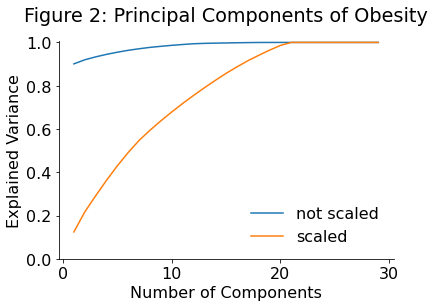

In [25]:
#PCA
def explained(scale):
    stages = [("cat", make_column_transformer((OneHotEncoder(), ['Gender', 'family_history_with_overweight','FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']), remainder = "passthrough")),
              ("imp", SimpleImputer(strategy="most_frequent"))]
    if scale:
        stages.append(("std", StandardScaler()))
    stages.append(("pca", PCA()))
    p = Pipeline(stages)
    p.fit(df[xcols])
    explained = p["pca"].explained_variance_
    s = pd.Series(explained.cumsum() / explained.sum(),
                  index=range(1, len(p.named_steps['cat'].get_feature_names())+1))
    print(s)
    return s

ax = explained(False).plot.line(label="not scaled", ylim=0)
explained(True).plot.line(label="scaled", ax=ax)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False, bbox_to_anchor=(1, 0), loc='lower right', ncol=1)
ax.set_title("Figure 2: Principal Components of Obesity", pad=20)


In [12]:
len(data2[data2["obesity"]==True])/len(data2)

0.4604452865940313

In [13]:
df["obesity"] = df['NObeyesdad'].map({'Obesity_Type_I': True, 'Obesity_Type_II': True, 'Obesity_Type_III': True, "Insufficient_Weight": False, "Normal_Weight": False, "Overweight_Level_I": False, "Overweight_Level_II": False})
df["obesity"].value_counts()

False    1139
True      972
Name: obesity, dtype: int64

In [14]:
# Logistic Regression
train, test = train_test_split(df, random_state=0)
train.shape, test.shape

((1583, 18), (528, 18))

In [34]:
p = Pipeline([
    ("cat", make_column_transformer((OneHotEncoder(), ['Gender', 'family_history_with_overweight','FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']), remainder = "passthrough")),
    ("std", StandardScaler()),
    ("lr", LogisticRegression())])
p.fit(train[xcols], train[ycol])
print("Score", p.score(test[xcols], test[ycol]))
print("Recall", recall_score(test[ycol], p.predict(test[xcols])))
print("Precision", precision_score(test[ycol], p.predict(test[xcols])))
print(confusion_matrix(test[ycol], p.predict(test[xcols])) / len(test) * 100)

Score 0.7803030303030303
Recall 0.8744939271255061
Precision 0.717607973421927
[[37.12121212 16.09848485]
 [ 5.87121212 40.90909091]]


In [30]:
cols = p.named_steps['cat'].get_feature_names()
cols = [t.replace("onehotencoder__", "") for t in cols]
cols = [t.replace("x0_", "") for t in cols]
cols = [t.replace("x1", "family history with overweight") for t in cols]
cols = [t.replace("x2", "FAVC") for t in cols]
cols = [t.replace("x3", 'CAEC') for t in cols]
cols = [t.replace("x4", 'SMOKE') for t in cols]
cols = [t.replace("x5", 'SCC') for t in cols]
cols = [t.replace("x6", 'CALC') for t in cols]
cols = [t.replace("x7", 'MTRANS') for t in cols]
c = pd.DataFrame(p["lr"].coef_[0], index = cols)
c.columns = ["values"]
data3 = c.sort_values(by = "values", key = abs, ascending = False)
data3 = data3.drop(["family history with overweight_no", "FAVC_no", "SCC_no", "SMOKE_no", "Male"], 0)[:10]

In [31]:
data3 = data3.rename(index={"family history with overweight_yes": "family history with overweight", "FAVC_yes":"FAVC"})
ordered = ['Age', 'family history with overweight', 'FAVC', 'FCVC', 'CAEC_Frequently', 'CAEC_Sometimes','FAF', 'MTRANS_Automobile','MTRANS_Public_Transportation','MTRANS_Walking']
data3 = data3.reindex(ordered)
data3

,values
Age,0.564291
family history with overweight,0.635900
FAVC,0.357831
FCVC,0.419904
CAEC_Frequently,-0.680960
CAEC_Sometimes,0.535062
FAF,-0.226313
MTRANS_Automobile,-0.229941
MTRANS_Public_Transportation,0.297014
MTRANS_Walking,-0.235440


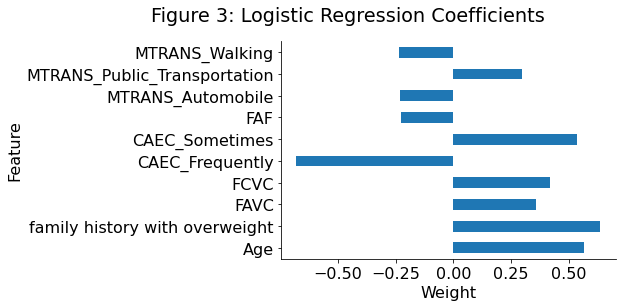

In [32]:
ax = data3.plot.barh()
ax.get_legend().remove()
ax.set_xlabel("Weight")
ax.set_ylabel("Feature")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Figure 3: Logistic Regression Coefficients", pad=20)
ax.title.set_position([0.2, 1.1])